In [2]:
import numpy as np
import matplotlib.pyplot as plt
import mnns

                Type: JDA
               Wires: 94
          Electrodes: 2
Inner-wire junctions: None
      Wire junctions: 170
              Length: 28.00 um (4.000 l0)
               Width: 28.00 um (4.000 l0)
        Wire Density: 0.1199 um^-2 (5.875 l0^-2)


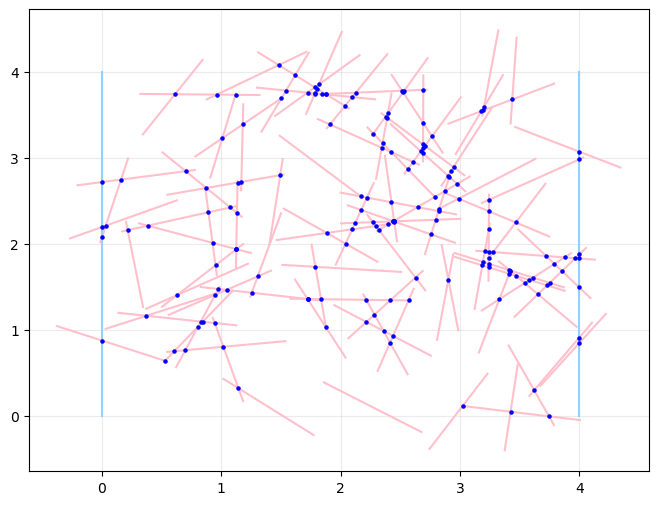

In [ ]:
# Create a NWN
NWN = mnns.create_NWN(
    shape = (4, 4),
    seed = 15, 
    density = 5.875
)

# Add electrodes to the NWN
left, right = mnns.add_electrodes(NWN, "left", "right")

# Print details of the NWN
print(NWN)

# Plot NWN
fig, ax = mnns.plot_NWN(NWN)
plt.show()

In [ ]:
# Set model parameters
model = mnns.models.HP_model
NWN.resistance_function = "linear"
NWN.state_vars = ["x"]
NWN.set_state_var("x", 0.1)

# Set solver parameters
min_time = 0
max_time = 750
dt = 1.0
tol = 1e-7
t_eval = np.arange(min_time, max_time, dt)

# Define the voltage waveform
def voltage_func(t):
    t = np.atleast_1d(t)
    V0 = 20
    T = 125
    f = 1 / T
    phi = np.pi / 2

    # Vertical translated sine wave
    out = V0 * (np.sin(2*np.pi*f*t - phi) + 1) / 2

    # Reverse the sign half way through
    out[t > max_time//2] *= -1  

    return out

# Use the Strukov window function
def window_func(x):
    x = np.clip(x, 0, 1)
    return x * (1 - x)

# Evolve NWN to find state variables over time
args = (NWN, left, right, voltage_func, window_func)
sol = NWN.evolve(model, t_eval, args=args, ivp_options={"rtol": tol, "atol": tol})

# Fine current though the drain electrode
I = mnns.get_evolution_current(NWN, sol, left, right, voltage_func)

# Scale the quantities by the right units
scaled_V = voltage_func(sol.t) * NWN.units["v0"]
scaled_I = I * NWN.units["i0"]
scaled_t = sol.t * NWN.units["t0"] * 1e-6

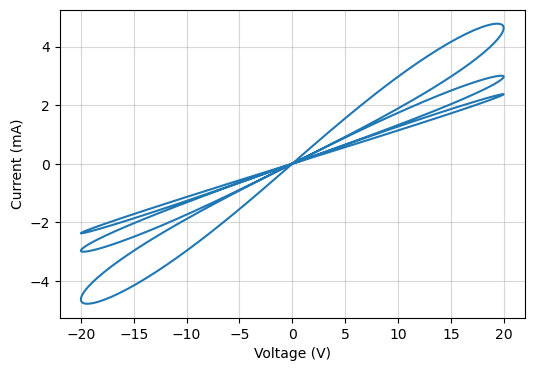

In [5]:
# Plot hysteresis curve
fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(scaled_V, scaled_I * 1e3)
ax.grid(alpha=0.5)
ax.set_xlabel("Voltage (V)")
ax.set_ylabel("Current (mA)")
plt.show()